# Asignemnt: MNIST GAN
## Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`.

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. Makes generation easier...

In [ ]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


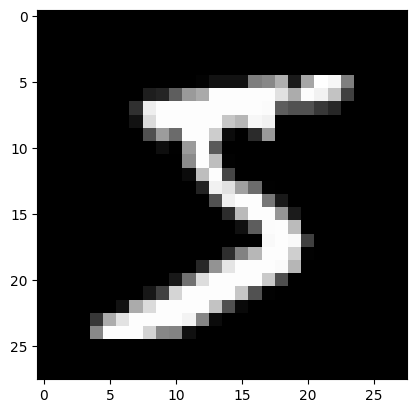

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 9, 9, 4, 2, 6, 2, 6, 6, 1, 6, 5, 6, 1, 1, 3, 2, 3, 6, 5, 2, 6, 1, 7,
        3, 6, 2, 5, 7, 7, 7, 2, 4, 3, 5, 1, 7, 1, 3, 5, 0, 7, 2, 7, 1, 6, 8, 0,
        4, 8, 7, 3, 9, 2, 3, 2, 1, 4, 0, 4, 7, 1, 8, 3, 7, 2, 9, 4, 9, 3, 0, 9,
        0, 0, 1, 7, 9, 1, 4, 8, 3, 6, 1, 4, 8, 7, 7, 7, 2, 0, 3, 4, 1, 5, 1, 2,
        1, 3, 9, 9])


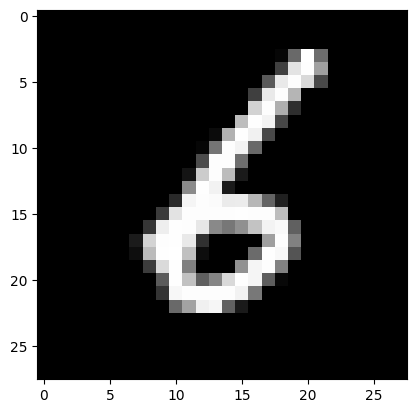

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## 1. Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),   # 784 → 256
    nn.LeakyReLU(0.2, inplace=True),

    nn.Linear(hidden_size, hidden_size),  # 256 → 256
    nn.LeakyReLU(0.2, inplace=True),

    nn.Linear(hidden_size, 1),            # 256 → 1 (Real vs Fake)
    nn.Sigmoid()                          # Ausgabe ∈ (0, 1)
)


In [ ]:
D.to(device);

## 2. Build Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [ ]:
latent_size = 64

In [ ]:
import torch.nn as nn

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),   # 64 → 256
    nn.ReLU(inplace=True),

    nn.Linear(hidden_size, hidden_size),   # 256 → 256
    nn.ReLU(inplace=True),

    nn.Linear(hidden_size, image_size),    # 256 → 784
    nn.Tanh()                              # Ausgabe ∈ [-1, 1]
).to(device)


## 3. Train the Model

* train the model
* save samples of generated images after each epoch -> use the ``denorm()`` function

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.utils as vutils
from datetime import datetime

# -------------------- Hyper-Parameter --------------------
num_epochs      = 50
lr              = 2e-4           # Adam-Default aus Goodfellow-Paper
beta1, beta2    = 0.5, 0.999     # stabilere Momente (Radford et al. 2016)
sample_dir      = 'samples'

os.makedirs(sample_dir, exist_ok=True)

criterion = nn.BCELoss()
opt_D     = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
opt_G     = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

# Für konstante Visualisierung
fixed_noise = torch.randn(64, latent_size, device=device)

# -------------------- Monitoring-Arrays --------------------
loss_D_hist, loss_G_hist = [], []              #  << neu

# -------------------- Training-Loop --------------------
for epoch in range(1, num_epochs + 1):
    for real, _ in data_loader:
        batch = real.size(0)
        real   = real.view(batch, -1).to(device)

        # ----- 1. Discriminator -----
        real_lbl = torch.ones(batch, 1, device=device)
        fake_lbl = torch.zeros(batch, 1, device=device)

        out_real = D(real)
        loss_D_real = criterion(out_real, real_lbl)

        z    = torch.randn(batch, latent_size, device=device)
        fake = G(z).detach()
        out_fake = D(fake)
        loss_D_fake = criterion(out_fake, fake_lbl)

        loss_D = loss_D_real + loss_D_fake
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ----- 2. Generator -----
        z    = torch.randn(batch, latent_size, device=device)
        fake = G(z)
        gen_lbl = torch.ones(batch, 1, device=device)   # Generator will "real"
        out = D(fake)
        loss_G = criterion(out, gen_lbl)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # ---------- Logging & Samples ----------
    loss_D_hist.append(loss_D.item())          #  << neu
    loss_G_hist.append(loss_G.item())          #  << neu
    # -------------------- Logging & Samples --------------------
    print(f"[{datetime.now().strftime('%H:%M:%S')}] "
          f"Epoch [{epoch:03}/{num_epochs}] "
          f"L_D: {loss_D.item():.4f}  L_G: {loss_G.item():.4f}")

    with torch.no_grad():
        fake = G(fixed_noise).view(-1, 1, 28, 28)
        fake = denorm(fake)               # zurück nach [0,1]
        vutils.save_image(fake,
                          os.path.join(sample_dir, f"epoch_{epoch:03}.png"),
                          nrow=8, padding=2)
        # → 8 × 8-Grid der jeweils gleichen latenten Punkte

# -------------------- Loss-Plot --------------------
plt.figure(figsize=(6,4))
plt.plot(loss_D_hist, label='Discriminator')
plt.plot(loss_G_hist, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss on MNIST')
plt.legend()
plt.tight_layout()
plt.show()
